# Setup

 Import standard modules

In [69]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
os.chdir('/home/chris/projects/tidal_flat_0d')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from src import features, models
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [779]:
import time
def aggrade_fd(times, tide_fun, init_land_elev, bound_conc, settle_rate, bulk_dens,):
    start_time = time.perf_counter()
    land_elev = np.array([init_land_elev, init_land_elev])
    conc = np.array([0.0, 0.0])
    depth = np.array([tide_fun(0) - init_land_elev])
    status = 0
    index = np.arange(0, len(times))
    dt = times[1] - times[0]
    for i in index[1:-1]:
        t = times[i]
        depth = np.append(depth, tide_fun(t) - land_elev[i])
        if depth[i] < 0.0015:
            conc = np.append(conc, 0.0)
            land_elev = np.append(land_elev, land_elev[-1])
            continue

        if (depth[i] - depth[i-1]) > 0:
            delta_conc = - settle_rate * conc[i] / depth[i] * dt - 1 / depth[i] * (conc[i] - bound_conc) * (depth[i] - depth[i-1])
        elif (depth[i] - depth[i-1]) <= 0:
            if status == 0:
                slack = times[i]
                status = 1
            delta_conc = - settle_rate * conc[i] / depth[i] * dt
            
        if delta_conc < 0 and abs(delta_conc) > conc[i]:
            print("Extracted too much")
            delta_conc = - conc[i]
            
        conc = np.append(conc, conc[i] + delta_conc)
        delta_land_elev = settle_rate * conc[i] / bulk_dens * dt
        land_elev = np.append(land_elev, land_elev[i] + delta_land_elev)
        
    depth = np.append(depth, tide_fun(i+1) - land_elev[i])
    print("Aggradation:           {:.2e} m".format(land_elev[-1] - land_elev[0]))
    print("Degradation:           {:.2e} m".format(0.0))
    print("Elevation change:      {:.2e} m".format(land_elev[-1] - land_elev[0]))
    print("Final elevation:       {:.4f} m".format(land_elev[-1]))
    print("Runtime:               {}".format(time.strftime("%H:%M:%S", time.gmtime(time.perf_counter() - start_time))))

    return slack, np.stack((times, depth, conc, land_elev))

In [155]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)
# tides = tides.iloc[:int(len(tides) * 0.35)]

In [156]:
from src import models

sim = models.Simulation(
    tide_elev=tides.values,
    land_elev_init=1.15,
    index=np.arange(0, len(tides)),
    conc_init=0.0,
    conc_bound=1.0,
    grain_diam=3.5e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate=2e-4,
    comp_rate=4e-3,
    sub_rate=3e-3,
    slr=0.0,
    method="DOP853",
    runs=1,
    min_depth=0.0015,
    dense_output=False,
    save_inundations=False,
)
sim.simulate()

Aggradation:           3.48e-02 m
Degradation:           -6.19e-03 m
Elevation change:      2.83e-02 m
Final elevation:       1.1783 m
Runtime:               00:03:11


In [147]:
sim.results

SimulationResults @6253a0 
data=           tide_elev  land_elev
0.0        -0.863023   1.150000
1.0        -0.863186   1.150000
2.0        -0.863348   1.150000
3.0        -0.863511   1.150000
4.0        -0.863674   1.150000
...              ...        ...
3153599.0   0.200945   1.149384
3153599.0   0.200945   1.149384
3153599.0   0.200945   1.149384
3153599.0   0.200945   1.149384
3153599.0   0.200945   1.149384

[3148316 rows x 2 columns]
degradation=-0.0004118916286149163
aggradation=6.252812999174573e-05
start_time=201478.792155396
end_time=201606.563776999

In [835]:
dense = sim.inundations[0].result.flood.sol(np.arange(sim.inundations[0].start_pos, sim.inundations[0].slack_pos, 1))

In [841]:
available = dense[0] * dense[1]
extracted = dense[1] * settle_rate

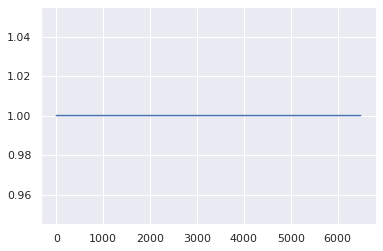

In [845]:
plt.plot(available >= extracted)

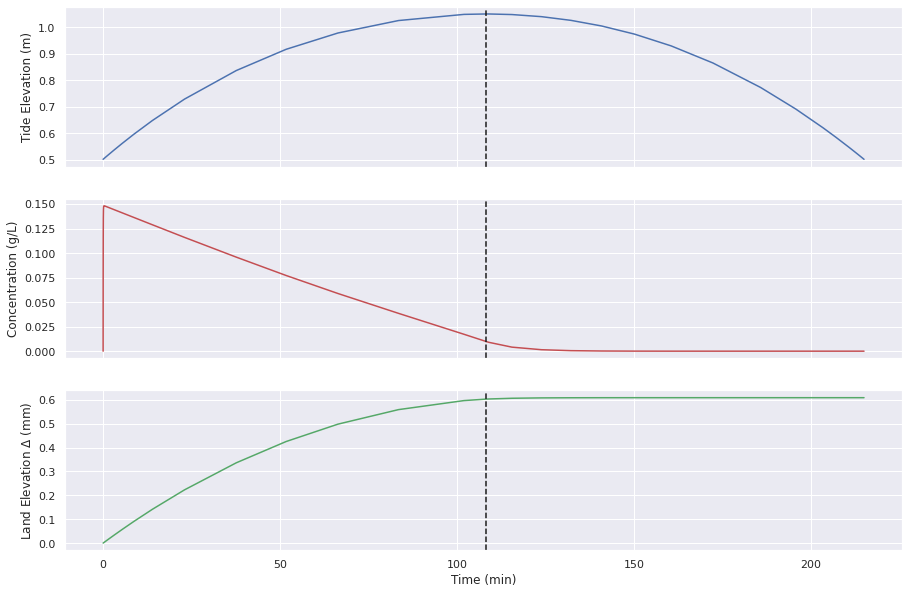

In [829]:
sim.inundations[0].result.plot()

In [795]:
DT = 1
fd_times = np.arange(0, len(tides), DT)
tide_fun = scipy.interpolate.InterpolatedUnivariateSpline(x=np.arange(0, len(tides)), y=tides.values)

slack, fd_result = aggrade_fd(
    times=fd_times,
    tide_fun=tide_fun,
    init_land_elev=init_land_elev,
    bound_conc=bound_conc,
    settle_rate=models.stokes_settling(grain_dia, grain_dens),
    bulk_dens=bulk_dens,
)
fd_aggradation = fd_result[3][-1] - fd_result[3][0]
"Percent Diff: {:.4f} %".format(abs(fd_aggradation - sim.results.aggradation) / (fd_aggradation + sim.results.aggradation) / 2 * 100)

Aggradation:           6.09e-04 m
Degradation:           0.00e+00 m
Elevation change:      6.09e-04 m
Final elevation:       0.5006 m
Runtime:               00:00:01


'Percent Diff: 0.0160 %'

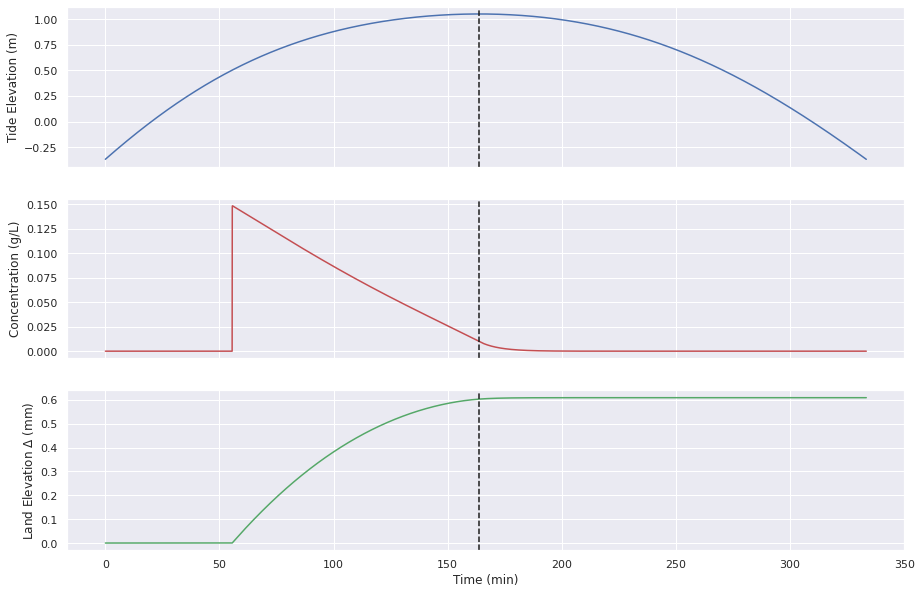

In [797]:
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
loc = np.where(fd_result[0] > 0.0015)[0][0]
i = fd_times[loc:] / 60
c = fd_result[2][loc:]
e = fd_result[3][loc:]


axs[0].plot(i, tide_fun(fd_times[loc:]), color="b")
axs[0].set(ylabel="Tide Elevation (m)")
axs[0].set(xticklabels=[])
axs[1].plot(i, c, color="r")
axs[1].set(ylabel="Concentration (g/L)",)
axs[1].set(xticklabels=[])
axs[2].plot(i, (e - fd_result[3][0])  * 1000, color="g")
axs[2].set(ylabel="Land Elevation $\Delta$ (mm)",xlabel="Time (min)")
for ax in axs:
    ax.axvline(slack / 60, color="k", linestyle="--")

In [559]:
extracted

array([0.00000000e+00, 1.41669398e-07, 1.26178394e-05, 1.17376614e-04,
       2.53875313e-04, 4.21997407e-04, 6.53024735e-04, 1.01642345e-03,
       1.65984487e-03, 2.93293841e-03, 5.75910914e-03, 1.26525871e-02,
       2.83600132e-02, 5.40511715e-02, 8.60998177e-02, 1.27363998e-01,
       1.81973094e-01, 2.33378566e-01, 1.66297561e-01, 1.01781723e-01,
       1.69995439e-02])

In [810]:
integ = sim.inundations[0].result.flood
dt = np.diff(integ.t)
C = integ.y[1]
E = integ.y[2]
D = integ.y[0] - integ.y[2]
available = D[:-1] * C[:-1]
extracted = C[:-1] * dt * settle_rate
check = available >= extracted
available_per_step = (dt * available)
extracted_per_step = (dt * extracted)

In [824]:
np.sum(extracted_per_step)

429.5283888575035

In [822]:
(integ.y[2][-1] - integ.y[2][0]) * bulk_dens

0.5428832853809906

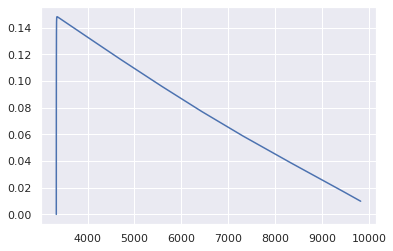

In [826]:
plt.plot(integ.t, C)

In [827]:
C

array([0.        , 0.00140373, 0.01463418, 0.07637708, 0.11587218,
       0.13575362, 0.14422764, 0.14724893, 0.14806642, 0.14811717,
       0.14787396, 0.1473466 , 0.14626416, 0.14423396, 0.14100289,
       0.13623012, 0.12881679, 0.11595689, 0.095832  , 0.07712174,
       0.05876178, 0.03854368, 0.01721327, 0.00988448])